---
### [Introduction](#intro)
### [Objective](#objective)
### [Exploratory Data Analysis (EDA)](#eda)
* [Understand - Structure & Variable Distribution](#understand)
* [Clean - Feature Engineer, Scale, Balance, & Outlier Handling](#clean)
* [Analyze Relationships](#relate)
* [Use Spark on RDD structure](#RDD)

### [Modeling](#model)
* [Decision Tree](#Tree)
* [Random Forest ](#Forest)
* [Logistic Regression](#logistic)
* [Confusion-matrix-> Decision Tree](#CTree)
* [Confusion-matrix-> Random Forest ](#CForest)
* [Confusion-matrix-> Logistic Regression](#Clogistic)

### [Conclusions](#outro)
---

<a id="intro"></a>
## Introduction

According to the Federal Bureau of Investigation, "Credit card fraud is the unauthorized use of a credit or debit card, or similar payment tool (ACH, EFT, recurring charge, etc.), to fraudulently obtain money or property. Credit and debit card numbers can be stolen from unsecured websites or can be obtained in an identity theft scheme."

In the FTC's Consumer Sentinel Network Data Book 2019 it was noted that "Credit card fraud tops the list of identity theft reports in 2019. The FTC received more than 271,000 reports from people who said their information was misused on an existing account or to open a new credit card account. The Nilson Report, the leading global card and mobile payments trade publication, releases annual fraud statistics and indicated in the November 2019 issue that global losses had amounted to \\$27.85 billion. The United States which represents 21.54% of transactions accounted for \\$9.47 or 33.99% of the gross worldwide losses.  

With data breaches becoming more common in recent years we can imagine that these numbers will continue to rise presenting an opportunity for credit card companies to take a proactive stance on detecting fraudulent charges quickly. We will explore various models utilizing a credit card transaction data set from Kaggle and evaluating which has the best performance metrics for classifying an incoming transaction as fraudulent or normal.

The data set is provided by [The Machine Learning Group (MLG)](https://mlg.ulb.ac.be/wordpress/) of [Université Libre de Bruxelles (ULB)](https://www.ulb.be) and contains transactions made by european cardholders in September 2013.

## Objective
The primary goal of this notebook is to develop a highly performant model for detecting fraudulent credit card transactions that could be utilized by our client the credit card company. Along the way we will outline a generalized end to end process for completing a machine learning project from data load to model validation and insights derived from the ultimate solution.

<a id="eda"></a>
## Exploratory Data Analysis (EDA)

First we need to explore the data set to **understand** our variables,
**clean** our dataset, and **analyze relationships** between variables. Ultimately EDA should allow us to answer the following questions from Daniel Bourke's article [A Gentle Introduction to Exploratory Data Analysis](https://towardsdatascience.com/a-gentle-introduction-to-exploratory-data-analysis-f11d843b8184):
* *What question(s) are you trying to solve (or prove wrong)?*
* *What kind of data do you have and how do you treat different types?*
* *What’s missing from the data and how do you deal with it?*
* *Where are the outliers and why should you care about them?*
* *How can you add, change or remove features to get more out of your data?*

While we won't explicitly answer these questions in this paper we will approach understanding, cleaning, and analyzing with them in mind. Before we begin it is important to remember that except for `Time` and `Amount` all explanatory variables are transformed due to privacy reasons. The explanatory variables were transformed through [prinicpal component analysis or PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and no further information can be provided regarding features `V1, V2, ..., V28`.

`Time` contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature `Amount` is the transaction amount, this feature can be used for example-dependant cost-senstive learning. Finally the feature `Class` is the response variable and it takes value 1 in case of fraud and 0 otherwise.

<a id="understand"></a>
### Understand - Structure & Variable Distribution
We start by reading in the credit card transaction data set CSV file as a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object and look a sample of some records using the [sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method. Then begin exploring using the [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to obtain descriptive statistics about each of the available variables.

# loading required libraries

In [6]:
%pip install pyspark

In [7]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, when
from statistics import mode as _mode
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
from pyspark.ml.classification import RandomForestClassificationModel
import matplotlib.pyplot as plt

In [8]:
spark = SparkSession.builder.appName("Fraud-Detection").getOrCreate()

### Loading the Dataset

In [9]:
Creditcard = spark.read.csv("/content/creditcard.csv", inferSchema = True, header = True)

In [10]:
Creditcard.count()

19898

In [11]:
Creditcard.columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

### Finding Missing null values in each column

In [13]:
from pyspark.sql.functions import col

def missing():
    for column_name in Creditcard.columns:
        null_count = Creditcard.filter(col(column_name).isNull()).count()
        print(f"{column_name} has number of NULLs : {null_count}")
missing()

Time has number of NULLs : 0
V1 has number of NULLs : 0
V2 has number of NULLs : 0
V3 has number of NULLs : 0
V4 has number of NULLs : 0
V5 has number of NULLs : 0
V6 has number of NULLs : 0
V7 has number of NULLs : 0
V8 has number of NULLs : 0
V9 has number of NULLs : 0
V10 has number of NULLs : 0
V11 has number of NULLs : 0
V12 has number of NULLs : 0
V13 has number of NULLs : 0
V14 has number of NULLs : 0
V15 has number of NULLs : 0
V16 has number of NULLs : 0
V17 has number of NULLs : 0
V18 has number of NULLs : 0
V19 has number of NULLs : 0
V20 has number of NULLs : 0
V21 has number of NULLs : 0
V22 has number of NULLs : 0
V23 has number of NULLs : 0
V24 has number of NULLs : 0
V25 has number of NULLs : 0
V26 has number of NULLs : 0
V27 has number of NULLs : 0
V28 has number of NULLs : 0
Amount has number of NULLs : 0
Class has number of NULLs : 0


In [14]:
df_pandas = Creditcard.toPandas()

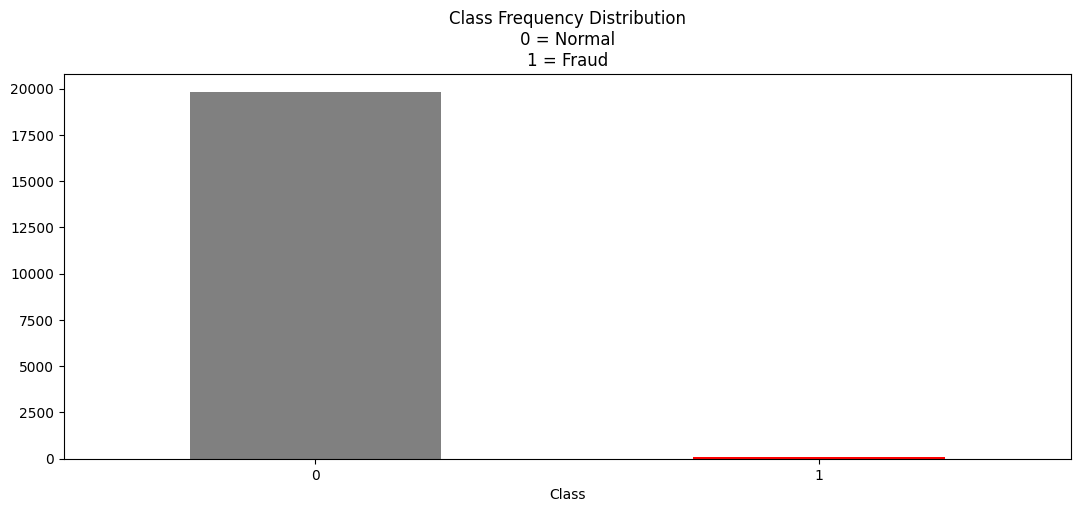

In [15]:
df_pandas['Class'].value_counts(sort=False).plot.bar(
    title="Class Frequency Distribution\n0 = Normal\n1 = Fraud",
    color=['grey','red'],
    rot=0,
    figsize=(13,5)
);

`Time` appears to be cyclical with periods every approximately `86000` seconds (24 hours). We will execute simple feature engineering to break out the various time components, e.g. hour, min, second. If the data contained at least 2 weeks worth of observations we could possibly extract the day of week component as there is often a weekly seasonality in transaction or sales data. We will subsequently scale the new time component features to align with the PCA variables.  

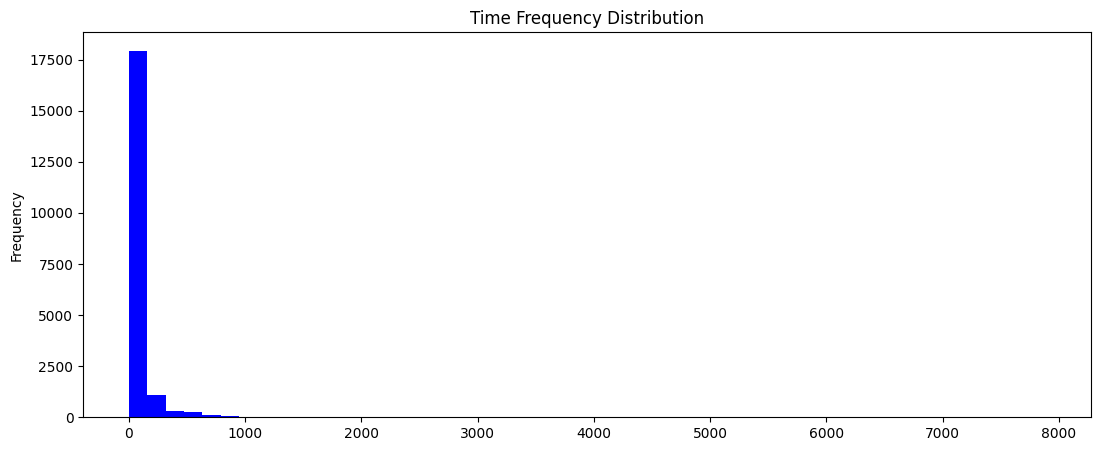

In [16]:
df_pandas['Amount'].plot.hist(
    title="Time Frequency Distribution",
    bins=50,
    color='blue',
    figsize=(13,5)
);

`Amount` is a highly skewed variable with maximum observed value of `25,691.16` however most transactions averaging at only `88`. Again because of the wide distribution of values we will scale the values down and align with the PCA variables. We should also note that `Amount` does not have any unit associated with it. Given the fact that the data was sourced in Europe which has many currencies and the fact that we will be scaling the variable later we will leave the numeric value unitless.

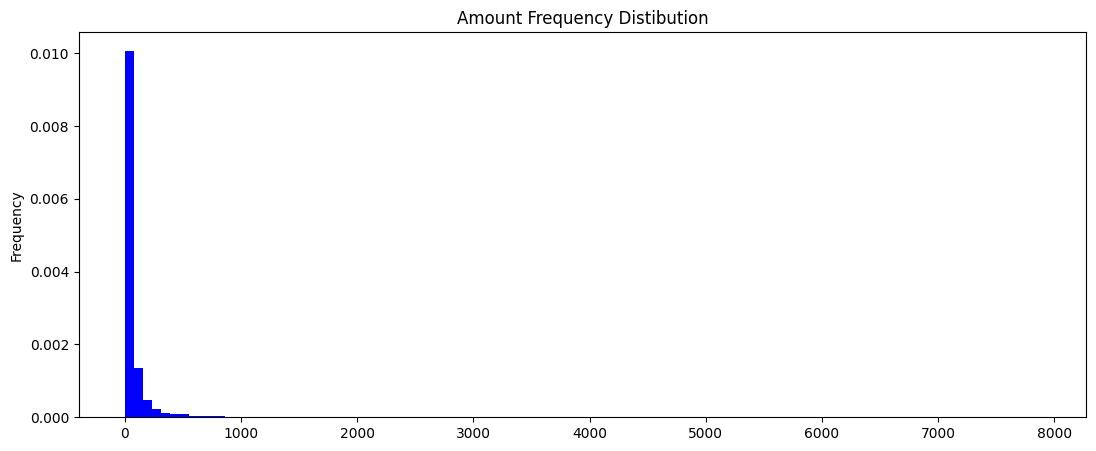

In [17]:
df_pandas['Amount'].plot.hist(
    title="Amount Frequency Distibution",
    bins=100,
    color='blue',
    figsize=(13,5),
    density=True
);

All of our PCA variables,`V1, V2, ..., V28`, as mentioned before have been transformed.

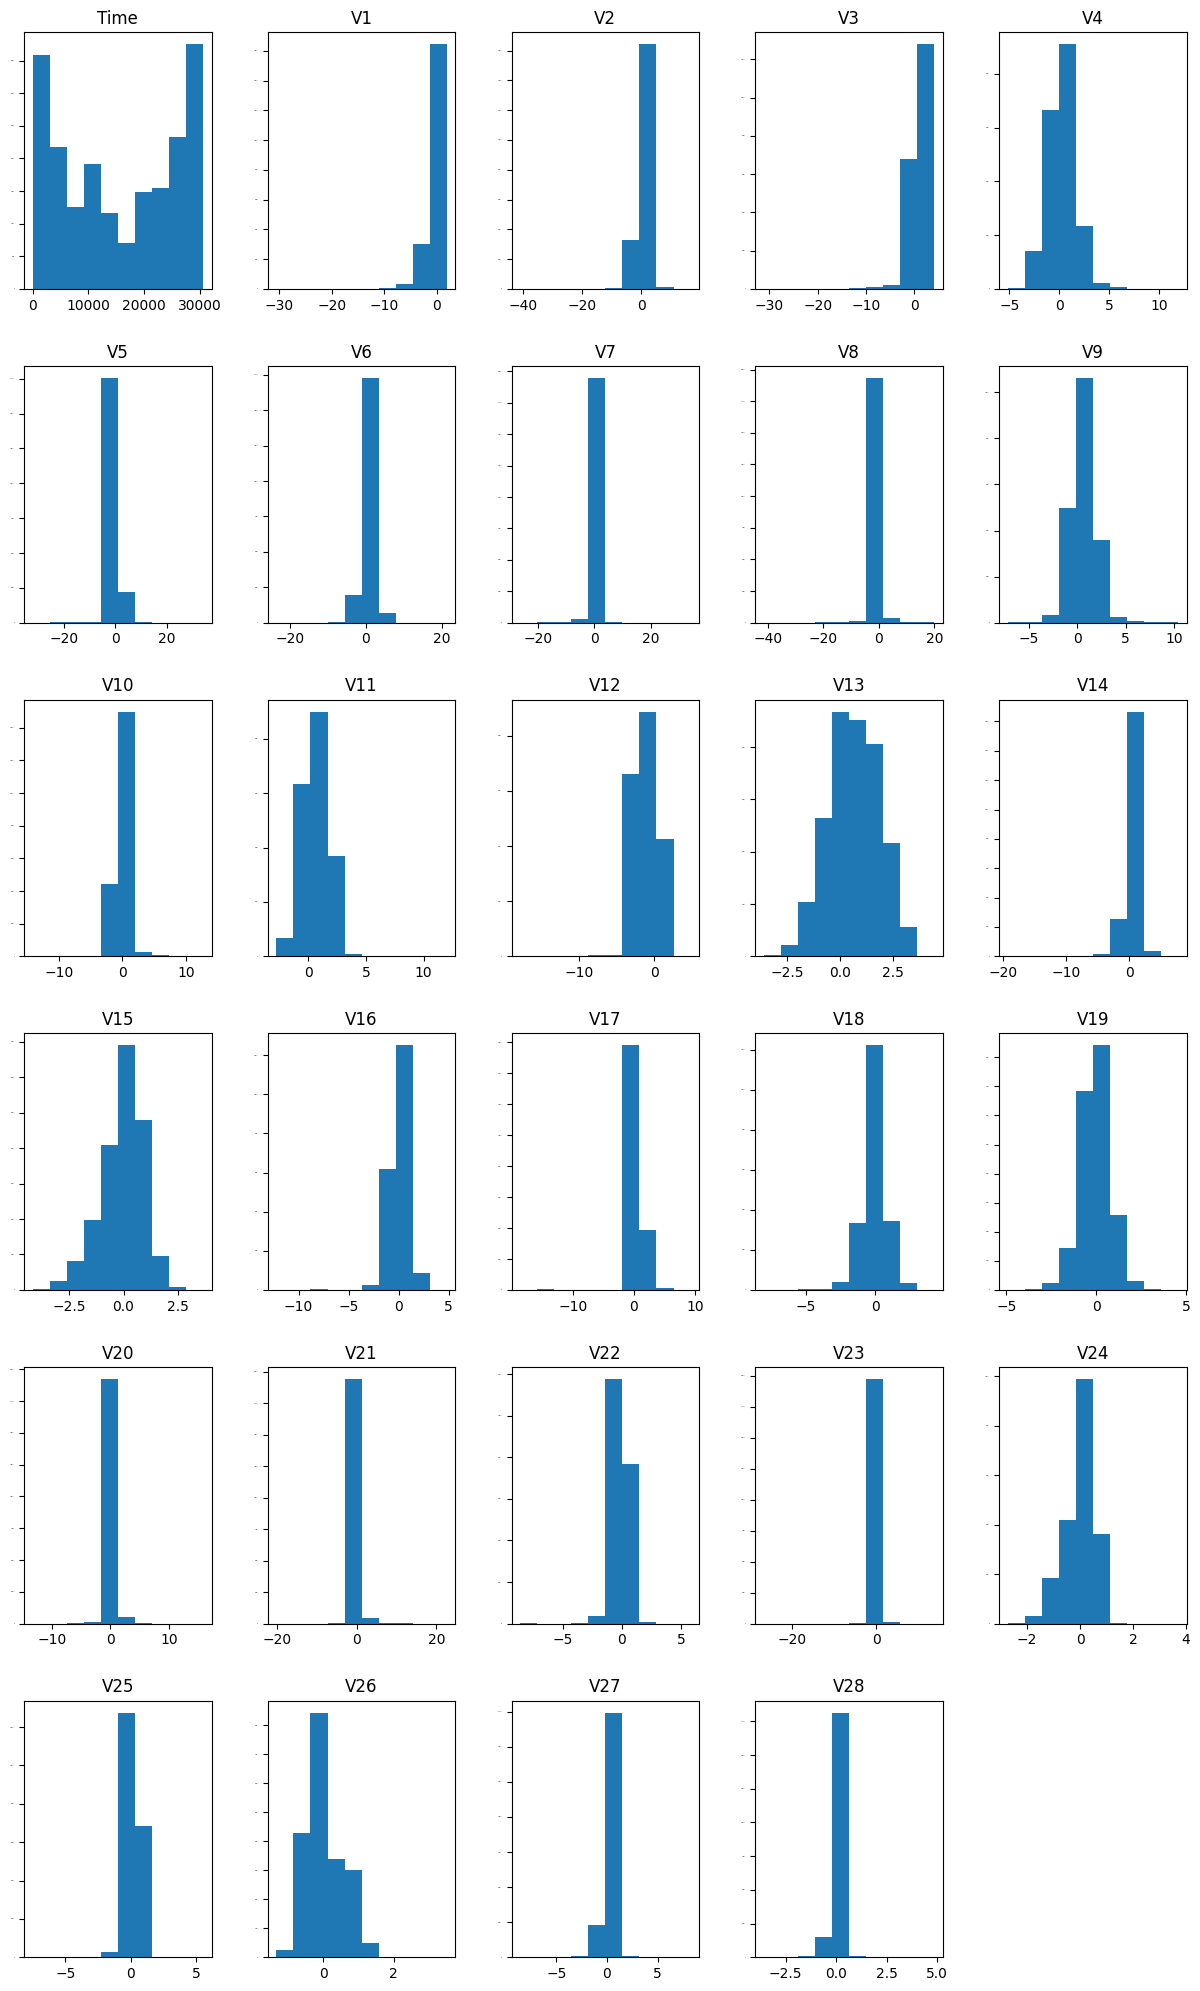

In [18]:
df_pandas.drop(['Amount','Class'],axis=1).hist(
    figsize=(15,25),
    ylabelsize=False,
    grid=False
);

Looking closer we can see some variety in the distributions even though all the PCA variables have mean values of `0`. Distributions of variables `V4`, `V12`, and `V28` are shown below. `V4` shows a slightly right skewed, `V12` appears to be left skewed, and `V28` shows a very narrow distribution. We will look at these distributions with respect to our target variable `Class` later as it might be that the normal transactions follow a normal distribution and that the fraudulent transactions are what are skewing these plots.

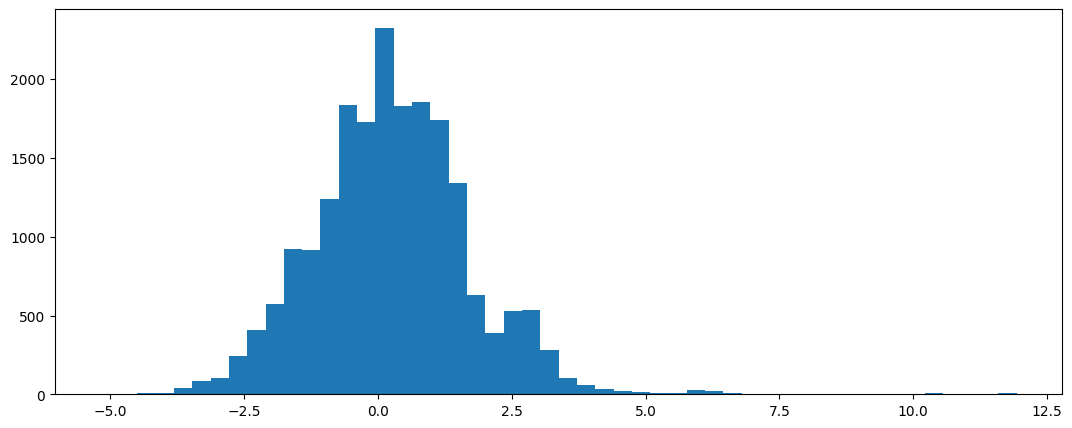

In [19]:
df_pandas.V4.hist(
    bins=50,
    figsize=(13,5),
    grid=False
);

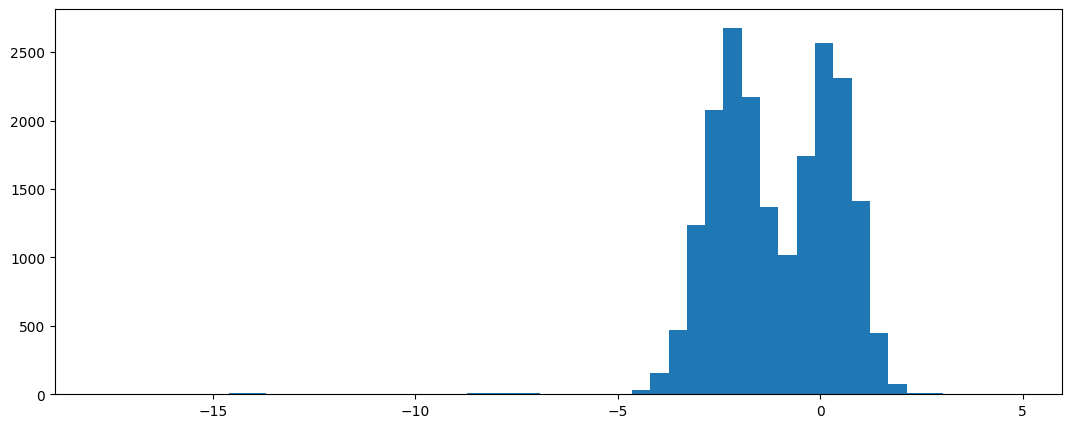

In [20]:
df_pandas.V12.hist(
    bins=50,
    figsize=(13,5),
    grid=False
);

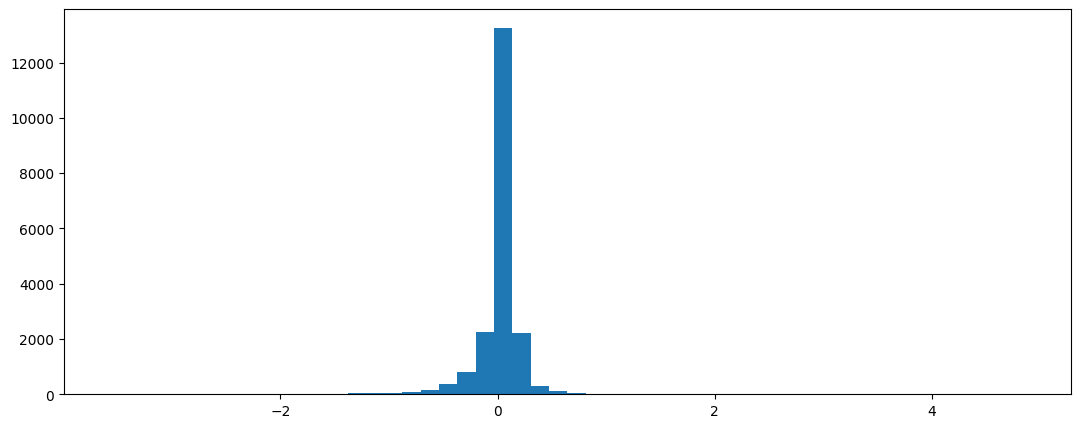

In [21]:
df_pandas.V28.hist(
    bins=50,
    figsize=(13,5),
    grid=False
);

In [22]:
Creditcard=Creditcard.drop('Time')

In [23]:
Creditcard.show(5)

+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|               

In [24]:
Creditcard=Creditcard.withColumnRenamed('Class','LABEL')

In [25]:
Creditcard.columns

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'LABEL']

## RDD Structure and parallesim

In [27]:
from pyspark.sql import SparkSession

# # Create SparkSession
# spark = SparkSession.builder \
#     .appName("CreditCardFraudDetection") \
#     .getOrCreate()

# Load data as DataFrame
data_df = spark.read.csv("/content/creditcard.csv", header=True, inferSchema=True)

# Filter out normal transactions (Class = 0)
normal_transactions_df = data_df.filter(data_df['Class'] == "0")

# Filter out fraudulent transactions (Class = 1)
fraudulent_transactions_df = data_df.filter(data_df['Class'] == "1")


In [28]:
# Count the number of normal transactions
num_normal_transactions = normal_transactions_df.count()

# Count the number of fraudulent transactions
num_fraudulent_transactions = fraudulent_transactions_df.count()

print("Number of Normal Transactions:", num_normal_transactions)
print("Number of Fraudulent Transactions:", num_fraudulent_transactions)

Number of Normal Transactions: 136479
Number of Fraudulent Transactions: 263


- We load the data from the CSV file into a DataFrame named `data_df`.

- We use the filter method on the DataFrame to create two separate DataFrames: normal_transactions_df containing  normal transactions `(Class = 0)` and fraudulent_transactions_df containing fraudulent transactions `(Class = 1)`.

- We count the number of transactions in each DataFrame using the count method.

- Finally, we print the number of normal and fraudulent transactions.

In [29]:
# Sum transaction amounts for normal transactions
total_normal_amount = data_df.filter(data_df['Class'] == 0).agg({'Amount': 'sum'}).collect()[0][0]

# Sum transaction amounts for fraudulent transactions
total_fraudulent_amount = data_df.filter(data_df['Class'] == 1).agg({'Amount': 'sum'}).collect()[0][0]

print("Total Normal Amount:", total_normal_amount)
print("Total Fraudulent Amount:", total_fraudulent_amount)

Total Normal Amount: 12494424.930002661
Total Fraudulent Amount: 30461.16999999999


- We map each transaction to a tuple containing the class label and 1.

- We reduce the tuples by class label to calculate the count of each class.

- We print the class counts.

- We sum the transaction amounts for normal and fraudulent transactions separately using DataFrame operations agg.

- Finally, we print the total amounts for normal and fraudulent transactions.

In [30]:
# Map: Extract class from each transaction
class_counts = data_df.rdd.map(lambda row: (row['Class'], 1))

# Reduce: Aggregate counts by class
class_counts = class_counts.reduceByKey(lambda x, y: x + y)

# Display class counts
print("Class Counts:")
for class_label, count in class_counts.collect():
    print(f"Class {class_label}: {count}")


Class Counts:
Class 0: 136479
Class 1: 263


## Monitoring a number of failed jobs and their names then tracking the runtime.

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import time

# Create a Spark session
spark = SparkSession.builder.appName("Fraud Detection").getOrCreate()

class JobMonitor:
    def __init__(self):
        self.failed_jobs = []
        self.job_start_times = {}
        self.job_end_times = {}

    def job_start(self, job_id):
        self.job_start_times[job_id] = time.time()

    def job_end(self, job_id, success):
        self.job_end_times[job_id] = time.time()
        if not success:
            self.failed_jobs.append(job_id)

    def print_failed_jobs(self):
        print("Failed Jobs and Their Runtimes:")
        for job_id in self.failed_jobs:
            start_time = self.job_start_times.get(job_id, 0)
            end_time = self.job_end_times.get(job_id, 0)
            runtime = end_time - start_time
            print(f"Job ID: {job_id}, Runtime: {runtime:.2f} seconds")


- JobMonitor Class: Defines a class to monitor job execution.
- Attributes:
  - failed_jobs: A list to store the IDs of failed jobs.
  - job_start_times: A dictionary to store the start time of each job.
  - job_end_times: A dictionary to store the end time of each job.
- Methods:
  - job_start(job_id): Records the start time of a job.
  - job_end(job_id, success): Records the end time of a job and logs if the job failed.
  - print_failed_jobs(): Prints the IDs and runtimes of failed jobs.

In [32]:
# Initialize the job monitor
job_monitor = JobMonitor()

# Function to simulate job execution and tracking
def run_job(df, job_id, simulate_failure=False):
    job_monitor.job_start(job_id)
    try:
        if simulate_failure:
            # Intentionally causing an error for testing
            df.select(col("non_existent_column")).show()
        else:
            # A valid operation
            df.show()
        job_monitor.job_end(job_id, success=True)
    except Exception as e:
        job_monitor.job_end(job_id, success=False)
        print(f"Job ID: {job_id} failed with exception: {e}")


- JobMonitor Instance: Create an instance of JobMonitor.
- run_job Function: Defines a function to simulate job execution.
  - Parameters:
    - df: The DataFrame on which operations are performed.
    - job_id: A unique identifier for the job.
    - simulate_failure: A flag to simulate job failure.
  - Execution Flow:
    - Starts the job and records the start time.
    - If simulate_failure is True, attempts to select a non-existent column, causing an error.
    - Otherwise, performs a valid DataFrame operation (showing the DataFrame).
    - Ends the job and records the end time, logging success or failure.

In [33]:
# Sample DataFrame
data = [(1, "Alice"), (2, "Bob"), (3, "Charlie")]
df = spark.createDataFrame(data, ["id", "name"])

# Run jobs
run_job(df.filter(col("id") > 2), job_id=1)
run_job(df, job_id=2, simulate_failure=True)  # This job is designed to fail

# Print failed jobs information
job_monitor.print_failed_jobs()


{"ts": "2025-12-24 17:11:31.252", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `non_existent_column` cannot be resolved. Did you mean one of the following? [`name`, `id`]. SQLSTATE: 42703", "context": {"file": "line 10 in cell [33]", "line": "", "fragment": "col", "errorClass": "UNRESOLVED_COLUMN.WITH_SUGGESTION"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o331.select.\n: org.apache.spark.sql.AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `non_existent_column` cannot be resolved. Did you mean one of the following? [`name`, `id`]. SQLSTATE: 42703;\n'Project ['non_existent_column]\n+- LogicalRDD [id#1664L, name#1665], false\n\n\tat org.apache.spark.sql.errors.QueryCompilationErrors$.unresolvedAttributeError(QueryCompilationErrors.scala:401)\n\tat org.apache.spark.sql.catalyst.analysi

+---+-------+
| id|   name|
+---+-------+
|  3|Charlie|
+---+-------+

Job ID: 2 failed with exception: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `non_existent_column` cannot be resolved. Did you mean one of the following? [`name`, `id`]. SQLSTATE: 42703;
'Project ['non_existent_column]
+- LogicalRDD [id#1664L, name#1665], false

Failed Jobs and Their Runtimes:
Job ID: 2, Runtime: 0.14 seconds


- Sample DataFrame: Create a small DataFrame with sample data.
- Run Jobs: Execute two jobs:
  - The first job filters the DataFrame where id > 2 and displays the result.
  - The second job simulates failure by attempting to select a non-existent column.
- Print Failed Jobs: Prints the IDs and runtimes of failed jobs.

In [34]:
# Show the first few rows of the DataFrame to inspect the values in the 'Class' column
data_df.select('Class').show()

+-----+
|Class|
+-----+
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
+-----+
only showing top 20 rows


In [35]:
Creditcard=Creditcard.withColumnRenamed('Class','LABEL')

In [36]:
Creditcard.columns

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'LABEL']

In [37]:
Features_List = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7','V8', 'V9','V10','V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17','V18', 'V19', 'Amount','LABEL']

In [38]:
for columns in Features_List:
     Creditcard= Creditcard.withColumn(columns, Creditcard[columns].cast(DoubleType()))

In [39]:
Creditcard.printSchema()

root
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nullable = true)
 |-- Amount: double (nul

In [40]:
assembler = VectorAssembler(inputCols = Features_List,outputCol = 'feature_vector')
dataframe = assembler.transform(Creditcard)

In [41]:
dataframe.show(5)

+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+--------------------+
|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|              

In [42]:
df_test, df_train = dataframe.randomSplit([0.3, 0.7], seed = 123)

In [43]:
df_test.count()

5977

In [44]:
df_train.count()

13921

<a id="model"></a>
## Modeling

Before we begin generating various predictive models from our Binary Classification problem it is important to discuss how we can assess model performance. [Amazon Machine Learning Developer Guide](https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html) indicates "typical metrics are accuracy (ACC), precision, recall, false positive rate, and F1-measure".

These evaluation metrics are calculated from four basic combinations of actual data cateogry and assigned category:
* **True Positive (TP)** - correct positive assignment
* **True Negative (TN)** - correct negative assignment
* **False Positive (FP)**  \[Type I Error\] - incorrect positive assignment   
* **False Negative (FN)**  \[Type II Error\] - incorrect negative assignment    

A confusion matrix, also known as an error matrix, is a 2x2 table that reflects these assignments. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class (or vice versa)
<p></p>

<img src="https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg" />


Accuracy (ACC) is the fraction of correct assignment (TP + TN)/(TP + TN + FP + FN), precision is the fraction of TP/(TP + FP), recall a.k.a. sensitivity is the fraction TP/(TP + FN), false positive rate is FP/(TN + FP), and finally F1-measure or F1-score is the "harmonic mean of precision and recall"

<p><center>$\normalsize F_1= \frac{2}{recall^{-1} + precision^{-1}} = 2  \frac{precision * recall}{precision + recall}=\frac{TP}{TP + \frac{1}{2}(FP + FN)}$</center></p>

Depending on the use case one might be more interested in a model that performs well for a specific metric or subset of metrics over others. For credit card fraud it is important that we have both high precision and high recall. F1-measure is often considered to be the most relevant measure in fraud detection due to its combination of of precision and recall into a single metric. Now that we know we need to evaluate our models to favor high recall or high sensitivity we need to split our data into train and test sets.

# Apply Machine Learning Classification Algorithms on the Dataset and Compare their Accuracy.

### Decision Trees

In [45]:
Decision_Tree_Classifier = DecisionTreeClassifier(labelCol = 'LABEL', featuresCol = 'feature_vector')
Decision_Tree_Model = Decision_Tree_Classifier.fit(df_train)

In [46]:
Decision_Tree_Prediction = Decision_Tree_Model.transform(df_test)

In [47]:
Decision_Tree_Prediction.show(5)

+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-----------------+-----------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------+-----+--------------------+-------------+-----------+----------+
|               V1|              V2|               V3|              V4|               V5|               V6|               V7|                V8|               V9|              V10|               V11|              V12|              V13|              V14|               V15|                V16|              V17|              V18|               V19|                 V20|              V21|               V22|   

In [48]:
Decision_Tree_Evaluator = MulticlassClassificationEvaluator(labelCol =  'LABEL', predictionCol = 'prediction')

In [49]:
Decision_Tree_Accuracy = Decision_Tree_Evaluator.evaluate(Decision_Tree_Prediction)

In [50]:
print('Decision Tree Accuracy is : ' + str(Decision_Tree_Accuracy * 100))
print('Test Error is : ' + str(1 - Decision_Tree_Accuracy))

Decision Tree Accuracy is : 100.0
Test Error is : 0.0


<a id="forest"></a>
### Random Forest

Random Forest models are in a different "meta-algorithm" class than the previous boosting models called bagging. Bagging is a method where weak learners are created in parallel, as opposed to boosting's sequential approach, and ultimately aggregated to create a kind of average of their individual outputs.[$^{37}$](#37) Random Forests utilize parallel decision trees as shown in the image below.

<p><img src="https://miro.medium.com/max/1306/0*f_qQPFpdofWGLQqc.png" /></p>

In [51]:
Random_Forest_Classifier = RandomForestClassifier(labelCol = 'LABEL', featuresCol = 'feature_vector',  maxDepth = 5,
    maxBins = 32, numTrees = 500, predictionCol='prediction')

In [52]:
Random_Forest_Model = Random_Forest_Classifier.fit(df_train)

In [53]:
Random_Forest_Prediction = Random_Forest_Model.transform(df_test)

In [54]:
Random_Forest_Prediction.show(5)

+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-----------------+-----------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------+-----+--------------------+--------------------+--------------------+----------+
|               V1|              V2|               V3|              V4|               V5|               V6|               V7|                V8|               V9|              V10|               V11|              V12|              V13|              V14|               V15|                V16|              V17|              V18|               V19|                 V20|              V21|      

In [55]:
Random_Forest_Evaluator = MulticlassClassificationEvaluator(labelCol = 'LABEL', predictionCol = 'prediction')

In [56]:
Random_Forest_Accuracy = Random_Forest_Evaluator.evaluate(Random_Forest_Prediction)

In [57]:
print('Random Forest Accuracy is : ' + str(Random_Forest_Accuracy * 100))
print('Test Error is : ' + str(1 - Random_Forest_Accuracy))

Random Forest Accuracy is : 100.0
Test Error is : 0.0


### Logisitic Regression
<a id="logistic"></a>

Logistic model uses the logistic or inverse logit function to model a binary or dichotomous variable. Similar to linear regression, logistic regression fits the data to a line however unlike linear regression the line is not straight but rather an S shaped curved called **Sigmoid**. The S shaped curve is bound on the Y axis between 0 and 1 which fits our goal of binary classification. The sigmoid function (shown below) provides us with a probability of an observation belonging to one of the two classes.

<p><center>$\normalsize sigmoid(x)= \frac{1}{1+e^{-x}} = \frac{e^{x}}{e^{x}+1}$</center></p>
<p></p>
Representative plots for a linear regression and logistic regression can be seen below.
<p><img src="https://miro.medium.com/max/1400/1*dm6ZaX5fuSmuVvM4Ds-vcg.jpeg" /></p>

In [58]:
Logistic_Regression_Classifier = LogisticRegression(regParam = 0.3, labelCol = "LABEL", featuresCol = 'feature_vector', \
                                       maxIter = 20,  elasticNetParam = 0.8,predictionCol='prediction')


In [59]:
Logistic_Regression_Model = Logistic_Regression_Classifier.fit(df_train)

In [60]:
Logistic_Regression_Prediction = Logistic_Regression_Model.transform(df_test)

Logistic_Regression_Prediction.show(5)

+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-----------------+-----------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------+-----+--------------------+--------------------+--------------------+----------+
|               V1|              V2|               V3|              V4|               V5|               V6|               V7|                V8|               V9|              V10|               V11|              V12|              V13|              V14|               V15|                V16|              V17|              V18|               V19|                 V20|              V21|      

In [61]:
Logistic_Regression_Evaluator = MulticlassClassificationEvaluator(labelCol = "LABEL", predictionCol = "prediction", \
                                                     metricName = "accuracy")

In [62]:
Logistic_Regression_Accuracy = Logistic_Regression_Evaluator.evaluate(Logistic_Regression_Prediction)

In [63]:
print('Logistic Regression Accuracy is : ' + str(Logistic_Regression_Accuracy * 100))
print('Test Error is : ' + str(1 - Logistic_Regression_Accuracy))

Logistic Regression Accuracy is : 99.58172996486532
Test Error is : 0.004182700351346824


# Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm.

### Decision Trees Model Performance

In [64]:
# Select only the prediction and label columns
predictions_and_labels = Decision_Tree_Prediction.select(['prediction', 'label'])

# Calculate true positive, false positive, false negative
tp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 1)).count()
fp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 0)).count()
fn = predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 1)).count()

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
confusion_matrix = predictions_and_labels.crosstab('prediction', 'label')
confusion_matrix.show()

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
+----------------+----+---+
|prediction_label| 0.0|1.0|
+----------------+----+---+
|             1.0|   0| 25|
|             0.0|5952|  0|
+----------------+----+---+



In [65]:
print(Decision_Tree_Prediction.printSchema())

root
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nullable = true)
 |-- Amount: double (nul

- Here is the flyweight design pattern principal that
  implemented on `DecisionTree`

In [67]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

class MetricsFlyweight:
    _metrics_cache = {}

    @classmethod
    def get_metrics(cls, key, predictions_and_labels):
        if key not in cls._metrics_cache:
            cls._metrics_cache[key] = cls._calculate_metrics(predictions_and_labels)
        return cls._metrics_cache[key]

    @staticmethod
    def _calculate_metrics(predictions_and_labels):
        tp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 1)).count()
        fp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 0)).count()
        fn = predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 1)).count()
        tn = predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 0)).count()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)

        return precision, recall, f1_score

class ConfusionMatrixFlyweight:
    _confusion_matrix_cache = {}

    @classmethod
    def get_confusion_matrix(cls, key, predictions_and_labels):
        if key not in cls._confusion_matrix_cache:
            cls._confusion_matrix_cache[key] = cls._calculate_confusion_matrix(predictions_and_labels)
        return cls._confusion_matrix_cache[key]

    @staticmethod
    def _calculate_confusion_matrix(predictions_and_labels):
        confusion_matrix = predictions_and_labels.crosstab('prediction', 'label')
        return confusion_matrix

def main():
    # Create SparkSession
    spark = SparkSession.builder \
        .appName("RandomForestMetrics") \
        .getOrCreate()

    # Read data from CSV file
    RandomForest_Prediction = spark.read.csv("/content/creditcard.csv", header=True, inferSchema=True)

    # Select only the prediction and label columns
    predictions_and_labels = Decision_Tree_Prediction.select(['prediction', 'label'])

    # Calculate metrics and confusion matrix using Flyweight pattern
    precision, recall, f1_score = MetricsFlyweight.get_metrics("metrics", predictions_and_labels)
    confusion_matrix = ConfusionMatrixFlyweight.get_confusion_matrix("confusion_matrix", predictions_and_labels)

    # Display metrics and confusion matrix
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("Confusion Matrix:")
    confusion_matrix.show()

if __name__ == "__main__":
    main()

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
+----------------+----+---+
|prediction_label| 0.0|1.0|
+----------------+----+---+
|             1.0|   0| 25|
|             0.0|5952|  0|
+----------------+----+---+



### Random Forest Model Performance

In [68]:
# Assuming RandomForest_Prediction is your DataFrame with prediction and label columns
# Replace this with your actual DataFrame
RandomForest_Prediction = spark.read.csv("/content/creditcard.csv", header=True, inferSchema=True)

# Select only the prediction and label columns
predictions_and_labels = Random_Forest_Prediction.select(['prediction', 'label'])

# Calculate true positive, false positive, false negative
tp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 1)).count()
fp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 0)).count()
fn = predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 1)).count()
tn = predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 0)).count()

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

# Display confusion matrix
confusion_matrix = predictions_and_labels.crosstab('prediction', 'label')
confusion_matrix.show()

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
+----------------+----+---+
|prediction_label| 0.0|1.0|
+----------------+----+---+
|             1.0|   0| 25|
|             0.0|5952|  0|
+----------------+----+---+



In [69]:
print(RandomForest_Prediction.printSchema())

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

- Here is the flyweight design pattern principal that
  implemented on `RandomForest`

In [71]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

class MetricsFlyweight:
    _metrics_cache = {}

    @classmethod
    def get_metrics(cls, key, predictions_and_labels):
        if key not in cls._metrics_cache:
            cls._metrics_cache[key] = cls._calculate_metrics(predictions_and_labels)
        return cls._metrics_cache[key]

    @staticmethod
    def _calculate_metrics(predictions_and_labels):
        tp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 1)).count()
        fp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 0)).count()
        fn = predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 1)).count()
        tn = predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 0)).count()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)

        return precision, recall, f1_score

class ConfusionMatrixFlyweight:
    _confusion_matrix_cache = {}

    @classmethod
    def get_confusion_matrix(cls, key, predictions_and_labels):
        if key not in cls._confusion_matrix_cache:
            cls._confusion_matrix_cache[key] = cls._calculate_confusion_matrix(predictions_and_labels)
        return cls._confusion_matrix_cache[key]

    @staticmethod
    def _calculate_confusion_matrix(predictions_and_labels):
        confusion_matrix = predictions_and_labels.crosstab('prediction', 'label')
        return confusion_matrix

def main():
    # Create SparkSession
    spark = SparkSession.builder \
        .appName("RandomForestMetrics") \
        .getOrCreate()

    # Read data from CSV file
    RandomForest_Prediction = spark.read.csv("/content/creditcard.csv", header=True, inferSchema=True)

    # Select only the prediction and label columns
    predictions_and_labels = Random_Forest_Prediction.select(['prediction', 'label'])

    # Calculate metrics and confusion matrix using Flyweight pattern
    precision, recall, f1_score = MetricsFlyweight.get_metrics("metrics", predictions_and_labels)
    confusion_matrix = ConfusionMatrixFlyweight.get_confusion_matrix("confusion_matrix", predictions_and_labels)

    # Display metrics and confusion matrix
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("Confusion Matrix:")
    confusion_matrix.show()

if __name__ == "__main__":
    main()


Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
+----------------+----+---+
|prediction_label| 0.0|1.0|
+----------------+----+---+
|             1.0|   0| 25|
|             0.0|5952|  0|
+----------------+----+---+



### Logistic Regression Model Performance

In [72]:
# Assuming LogisticRegression_Prediction is your DataFrame with prediction and label columns
# Replace this with your actual DataFrame
LogisticRegression_Prediction = spark.read.csv("/content/creditcard.csv", header=True, inferSchema=True)

# Select only the prediction and label columns
predictions_and_labels = Logistic_Regression_Prediction.select(['prediction', 'label'])

# Calculate true positive, false positive, false negative
tp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 1)).count()
fp = predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 0)).count()
fn = predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 1)).count()
tn = predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 0)).count()

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

# Display confusion matrix
confusion_matrix = predictions_and_labels.crosstab('prediction', 'label')
confusion_matrix.show()

Precision: 0
Recall: 0.0
F1 Score: 0
+----------------+----+---+
|prediction_label| 0.0|1.0|
+----------------+----+---+
|             0.0|5952| 25|
+----------------+----+---+



- Here is the singletone design pattern principal that
  implemented on `LogisticRegression`

In [73]:
class MetricsSingleton:
    _instance = None

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super(MetricsSingleton, cls).__new__(cls)
        return cls._instance

    def __init__(self, predictions_and_labels):
        self.predictions_and_labels = predictions_and_labels

    def calculate_metrics(self):
        tp = self.predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 1)).count()
        fp = self.predictions_and_labels.filter((col('prediction') == 1) & (col('label') == 0)).count()
        fn = self.predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 1)).count()
        tn = self.predictions_and_labels.filter((col('prediction') == 0) & (col('label') == 0)).count()

        precision = tp / (tp + fp) if (tp + fp)!= 0 else 0
        recall = tp / (tp + fn) if (tp + fn)!= 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall)!= 0 else 0

        return precision, recall, f1_score

def main():
    # Create SparkSession
    spark = SparkSession.builder \
      .appName("LogisticRegressionMetrics") \
      .getOrCreate()

    # Read data from CSV file
    LogisticRegression_Prediction = spark.read.csv("/content/creditcard.csv", header=True, inferSchema=True)

    # Select only the prediction and label columns
    predictions_and_labels = Logistic_Regression_Prediction.select(['prediction', 'label'])

    # Calculate metrics using Singleton pattern
    metrics = MetricsSingleton(predictions_and_labels)
    precision, recall, f1_score = metrics.calculate_metrics()

    # Display metrics
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)

    # Display confusion matrix
    confusion_matrix = predictions_and_labels.crosstab('prediction', 'label')
    confusion_matrix.show()

if __name__ == "__main__":
    main()

Precision: 0
Recall: 0.0
F1 Score: 0
+----------------+----+---+
|prediction_label| 0.0|1.0|
+----------------+----+---+
|             0.0|5952| 25|
+----------------+----+---+



## Conclusion
We applied the steps provided in project description from A to Z and you can make a comment if there is any misunderstanding or confusion with the project.